# Practice Problem: Heat Diffusion in 2D

Study thermal diffusion in 2D using the **Crank-Nicolson method**. Consider the diffusion of a quantity $u(x, y, t)$ over a two-dimensional spatial domain $ x\in = [-L_x,+L_x]$ and $y\in [-L_y,+L_y]$.

The governing equation for this process is the 2D diffusion equation:

$$
\frac{\partial u}{\partial t} = c \left( \frac{\partial^2 u}{\partial x^2} + \frac{\partial^2 u}{\partial y^2} \right)
$$

where $c$ is the diffusion coefficient.

At time $t=0$, the quantity $u(x, y, 0)$ is a **square pulse** centered at the origin $(0,0)$. Define this pulse such that its value is $1.0$ within the region $ [-L_x/4, L_x/4] \times [-L_y/4, L_y/4] $ and $0.0$ everywhere else. Implement **Dirichlet boundary conditions** where the value of $u$ is held at $0.0$ along all four edges of the domain ($x=-L_x, x=L_x, y=-L_y, y=L_y$) for all $t > 0$.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [13]:
# Parameters
Lx = Ly = 1.0           # Half-length of the domain; total domain = [-L, L]
Nx = Ny = 50            # Grid points
dx = 2 * Lx / (Nx - 1)
dy = 2 * Ly / (Ny - 1)
c = 1.0                 # Diffusion coefficient
dt = 0.001            # Time step
T = 0.1                # Total simulation time
Nt = int(T / dt)        # Number of time steps

print(Nt)

100


In [3]:
# Grid from -L to L
x = np.linspace(-Lx, Lx, Nx)
y = np.linspace(-Ly, Ly, Ny)
X, Y = np.meshgrid(x, y)


In [4]:
# Initial condition: square pulse at the center
u = np.zeros((Ny, Nx))
cx, cy = Nx // 2, Ny // 2
size = Nx // 4
u[cy - size:cy + size, cx - size:cx + size] = 1.0
u_new = u.copy()

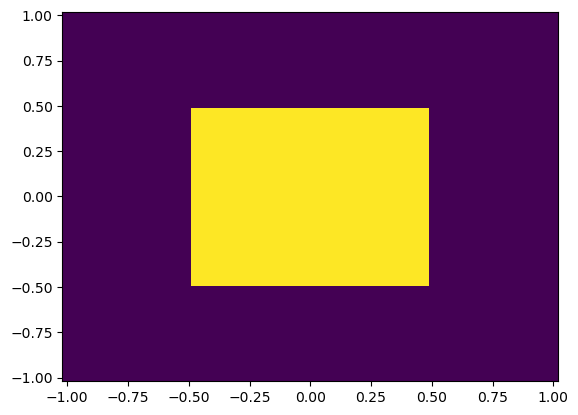

In [5]:
plt.figure()

plt.pcolor(X, Y, u)

plt.show()

In [6]:
# Crank–Nicolson setup
alpha = c * dt / dx**2

In [7]:
N = Nx * Ny
main_diag = np.ones(N) * (1 + 4 * alpha)
side_diag = np.ones(N - 1) * -alpha
updown_diag = np.ones(N - Nx) * -alpha

# Remove wrap-around across rows
for i in range(1, Ny):
    side_diag[i * Nx - 1] = 0

A = np.diag(main_diag)
A += np.diag(side_diag, k=1)
A += np.diag(side_diag, k=-1)
A += np.diag(updown_diag, k=Nx)
A += np.diag(updown_diag, k=-Nx)

#print(A)

In [8]:
b = u.flatten()
u_flat = np.linalg.solve(A, b)
u = u_flat.reshape((Ny, Nx))

u[0, :] = 0
u[-1, :] = 0
u[:, 0] = 0
u[:, -1] = 0



In [9]:
print(u.shape)

(50, 50)


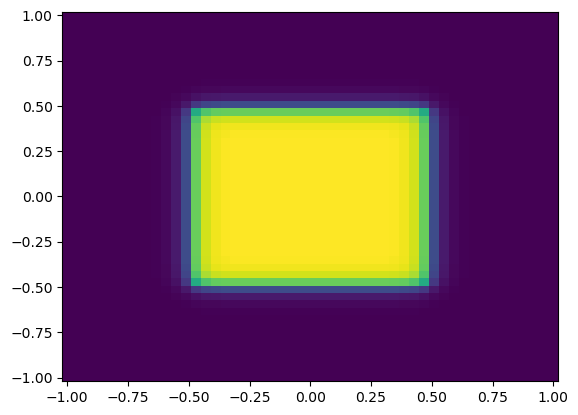

In [10]:
plt.figure()

plt.pcolor(X, Y, u)

plt.show()

In [14]:


# Initial condition: square pulse at the center
u = np.zeros((Ny, Nx))
cx, cy = Nx // 2, Ny // 2
size = Nx // 4
u[cy - size:cy + size, cx - size:cx + size] = 1.0
u_new = u.copy() # u_new is not used in the time loop below, so it's effectively redundant here.

# --- Prepare for Crank-Nicolson Time Stepping ---
# The A matrix for the implicit step (LHS of A * u_new_flat = b_vector)
# It represents (I - alpha * L_h), where L_h is the discretized Laplacian.
alpha = c * dt / dx**2

N = Nx * Ny
main_diag_A = np.ones(N) * (1 + 4 * alpha)
side_diag_A = np.ones(N - 1) * -alpha
updown_diag_A = np.ones(N - Nx) * -alpha

# Remove wrap-around for side_diag_A
for i in range(1, Ny):
    side_diag_A[i * Nx - 1] = 0

A = np.diag(main_diag_A)
A += np.diag(side_diag_A, k=1)  # Right neighbors
A += np.diag(side_diag_A, k=-1) # Left neighbors
A += np.diag(updown_diag_A, k=Nx) # Up neighbors
A += np.diag(updown_diag_A, k=-Nx) # Down neighbors

# The B matrix for the explicit part (RHS of A * u_new_flat = b_vector)
# It represents (I + alpha * L_h).
main_diag_B = np.ones(N) * (1 - 4 * alpha)
side_diag_B = np.ones(N - 1) * alpha
updown_diag_B = np.ones(N - Nx) * alpha

# Remove wrap-around for side_diag_B
for i in range(1, Ny):
    side_diag_B[i * Nx - 1] = 0

B = np.diag(main_diag_B)
B += np.diag(side_diag_B, k=1)
B += np.diag(side_diag_B, k=-1)
B += np.diag(updown_diag_B, k=Nx)
B += np.diag(updown_diag_B, k=-Nx)

# --- Define a function for boundary conditions for clarity ---
def apply_boundary_conditions(u_matrix):
    u_matrix[0, :] = 0  # Bottom boundary (y = -Ly)
    u_matrix[-1, :] = 0 # Top boundary (y = Ly)
    u_matrix[:, 0] = 0  # Left boundary (x = -Lx)
    u_matrix[:, -1] = 0 # Right boundary (x = Lx)
    return u_matrix

# Apply initial boundary conditions to the starting pulse
u = apply_boundary_conditions(u)

# --- Store all time snapshots ---
# Create a 3D array to store 'u' at each time step.
# It will have dimensions (Number of time steps + 1 for the initial state, Ny, Nx)
all_snapshots = np.zeros((Nt + 1, Ny, Nx))
all_snapshots[0, :, :] = u.copy() # Store the initial state (t=0)

# --- Main Time Loop for Crank-Nicolson ---
for n in range(Nt):
    # Calculate the right-hand side vector (b_vector) for the linear system.
    # This involves multiplying the B matrix by the flattened 'u' from the previous time step.
    b_vector = np.dot(B, u.flatten())

    # Solve the linear system A * u_new_flat = b_vector to get the new 'u' at t+dt.
    u_flat = np.linalg.solve(A, b_vector)

    # Reshape the flattened solution back into a 2D grid.
    u = u_flat.reshape((Ny, Nx))

    # Apply boundary conditions to the newly calculated 'u' field.
    u = apply_boundary_conditions(u)

    # Store the current 'u' field as a snapshot.
    all_snapshots[n + 1, :, :] = u.copy()


In [15]:
snapshot_index_to_plot = 200 # Plot the final snapshot

plt.figure(figsize=(8, 6))
# Use pcolormesh for a colored plot of the 2D field.
# We access the chosen snapshot from the all_snapshots array.
plt.pcolormesh(X, Y, all_snapshots[snapshot_index_to_plot, :, :], cmap='hot', shading='auto', vmin=0, vmax=1)
plt.colorbar(label='Concentration') # Add a color bar for scale
# Set the title to reflect the time of the displayed snapshot
plt.title(f'2D Diffusion (Crank-Nicolson) at Time = {snapshot_index_to_plot * dt:.4f} s')
plt.xlabel('x')
plt.ylabel('y')
plt.gca().set_aspect('equal', adjustable='box') # Ensure the plot looks spatially accurate (not stretched)
plt.show()

IndexError: index 200 is out of bounds for axis 0 with size 101

<Figure size 800x600 with 0 Axes>